In [50]:
import pandas as pd
from textblob import TextBlob
from sklearn.cluster import KMeans
import re
from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer
import string
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
import seaborn as sns
import matplotlib.pyplot as plt
from gensim import matutils, models
import scipy.sparse
from wordcloud import WordCloud
from collections import Counter
from   sklearn.manifold import MDS
from yellowbrick.text import UMAPVisualizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
import umap
import numpy as np
from sklearn.decomposition import NMF
from sklearn.cluster import SpectralClustering
from sklearn.cluster import DBSCAN, SpectralClustering, MeanShift
from sklearn.preprocessing import StandardScaler


In [185]:
df = pd.read_csv('new_tweets_data.csv')

In [186]:
df.shape

(14669, 29)

# Remove URLs

In [187]:
def remove_url(txt):
    """Replace URLs found in a text string with nothing"""
    return " ".join(re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", str(txt)).split())


In [188]:
df['text'] = [remove_url(tweet) for tweet in df['text']]

In [189]:
df['text'][4]

'BTC 017 7502Top last hAE 476 2713stOMG 246 10026stKBC 190 275stQNT 172'

# Remove Numbers and special characters

In [190]:
def clean_text_round1(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

round1 = lambda x: clean_text_round1(x)

In [191]:
df['clean_tweet']  = pd.Series(df['text'].apply(round1))

In [192]:
df['clean_tweet'][4]

'btc   last hae       '

# Dropping Duplicates

In [193]:
df['duplicated']=pd.Series(df['clean_tweet']).duplicated()

In [194]:
df.groupby('duplicated')['text'].count()
# 2488 duplicated tweets

duplicated
False    12181
True      2488
Name: text, dtype: int64

In [195]:
dropped_rows = [df.drop(index = i, inplace = True) for i, tweet in enumerate(df['duplicated']) if (tweet == True)]

In [196]:
df = df.reset_index(drop = True) 

In [197]:
df.groupby('duplicated')['text'].count()

duplicated
False    12181
Name: text, dtype: int64

# Tokenize

In [309]:

# Create our list of punctuation marks
punctuations = string.punctuation

# Create our list of stopwords
nlp = spacy.load('en')
#stop_words = [spacy.lang.en.stop_words.STOP_WORDS, 'blockchain', 'rt']
stop_words = spacy.lang.en.stop_words.STOP_WORDS
other_stop_word = ['blockchain', '1day', '1hour', '1week', 'hourly', 'october1st', 'yes', 'day', 'project', 'technology', 'new', 'news', 'team' ]
# Load English tokenizer, tagger, parser, NER and word vectors
parser = English()

# Creating our tokenizer function
def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = parser(sentence)

    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Removing stop words
    mytokens = [ word for word in mytokens if (word not in stop_words and word not in punctuations and word not in other_stop_word)]

    # return preprocessed list of tokens
    return mytokens

In [310]:
df['tweets_token'] = [spacy_tokenizer(word) for word in df['clean_tweet']]

# Vectorize using CountVectorizer

In [326]:
cv = CountVectorizer(lowercase=True,stop_words=['english', 'blockchain'],analyzer=spacy_tokenizer, binary=True)
text_counts= cv.fit_transform(df['clean_tweet'])

In [312]:
cv.vocabulary_

{'startups': 16412,
 'switzerlands': 16887,
 'crypto': 4525,
 'valleyblockchain': 18568,
 'switzerland': 16886,
 'interpret': 9515,
 'measureprotocol': 11257,
 'join': 9916,
 'hands': 8293,
 'build': 2714,
 'blockchainbased': 2101,
 'onlinegaming': 12624,
 'research': 14724,
 'community': 3868,
 'kotechanish': 10225,
 'chairman': 3233,
 'finboot': 7115,
 'bryanfoss': 2627,
 'visiting': 18780,
 'professor': 13866,
 'bristol': 2583,
 'business': 2767,
 'school': 15320,
 'argue': 1017,
 'softbank': 16056,
 'develop': 5292,
 'crosscarrier': 4481,
 'payments': 13079,
 'ibm': 8866,
 'tech': 17095,
 'softbankgroup': 16057,
 'smartphone': 15974,
 'btc': 2638,
 'hae': 8254,
 'event': 6536,
 'discussing': 5537,
 'hot': 8718,
 'topic': 17711,
 'daos': 4882,
 'organizations': 12749,
 'operate': 12677,
 'future': 7627,
 'api': 891,
 'beginners': 1628,
 'guide': 8203,
 'blockchainapi': 2090,
 'magecart': 10938,
 'attacks': 1205,
 'volusion': 18830,
 'ecommerce': 5926,
 'platform': 13398,
 'breached'

In [313]:
count_vect_df = pd.DataFrame(text_counts.toarray(), columns=cv.get_feature_names())
#count_vect_df.sample(20)

# Sentiment Analysis

In [314]:
def sentiment_analysis(text):
    for i in text.index:
        textB = TextBlob(text[i])
        sentiment = textB.sentiment.polarity
        df.set_value(i, 'Sentiment',sentiment)
        if sentiment <0.00:
            SentimentClass = 'Negative'
            df.set_value(i, 'SentimentClass', SentimentClass )
        elif sentiment >0.00:
            SentimentClass = 'Positive'
            df.set_value(i, 'SentimentClass', SentimentClass )
        else:
            SentimentClass = 'Neutral'
            df.set_value(i, 'SentimentClass', SentimentClass )

In [315]:
sentiment_analysis(df['clean_tweet'])

/home/arwa/anaconda3/envs/metis/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  """
/home/arwa/anaconda3/envs/metis/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  # This is added back by InteractiveShellApp.init_path()
/home/arwa/anaconda3/envs/metis/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
/home/arwa/anaconda3/envs/metis/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


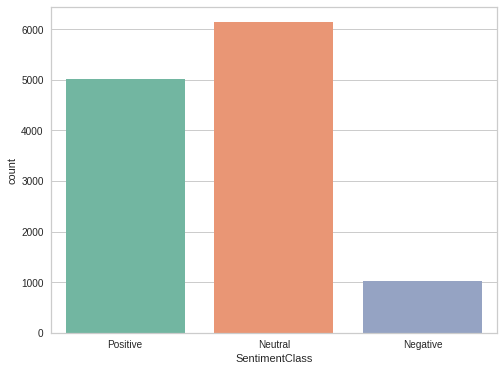

In [316]:
plt.figure(figsize=(8,6))
sns.countplot(x="SentimentClass", palette='Set2',data=df)

In [317]:
all_words = ' '.join([i for text in pd.Series(df['tweets_token']) for i in text])

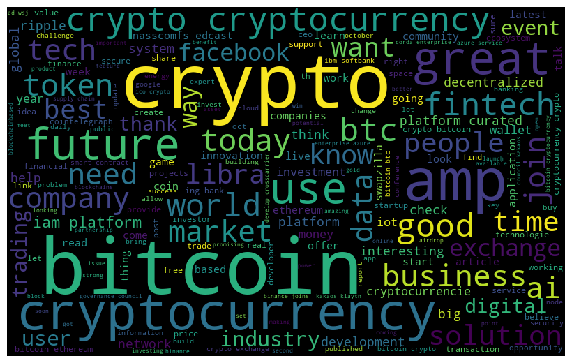

In [318]:
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

# Topic Modeling 

## NMF

In [367]:
nmf_model = NMF(50)
doc_topic_nmf = nmf_model.fit_transform(text_counts)

In [368]:
nmf_model.reconstruction_err_

282.306414104855

In [369]:
nmf_model = NMF(2)
doc_topic_nmf = nmf_model.fit_transform(text_counts)

In [370]:
nmf_model.reconstruction_err_

305.34302562286575

In [432]:
pd.Series(df.topic).value_counts()

0    8126
1    4055
Name: topic, dtype: int64

In [513]:
for index, topic in enumerate(nmf_model.components_):
    print(r"The top 20 words for topic # ", index)
    print([cv.get_feature_names()[i] for i in topic.argsort()[-20:]])

The top 15 words for topic #  0
['ico', 'employees', 'facebook', 'swapzilla', 'world', 'bank', 'binance', 'amp', 'research', 'work', 'exchanges', 'btc', 'fintech', 'exchange', 'libra', 'trading', 'industry', 'platform', 'cryptocurrency', 'crypto']
The top 15 words for topic #  1
['cryptocurrencies', 'digital', 'fintech', 'market', 'amp', 'money', 'reaction', 'swapzilla', 'token', 'default', 'congressman', 'like', 'trading', 'eth', 'ico', 'price', 'cryptocurrency', 'ethereum', 'btc', 'bitcoin']


In [324]:
topics_words_nmf = pd.DataFrame(nmf_model.components_, columns=cv.get_feature_names())

In [418]:
topics_words_nmf

,aadhar,aantonop,aantonoplibre,aapl,aas,ab,ababa,abadi,abandon,abbc,...,zugtheyre,zuid,zuker,zukerberg,zumzumfinancials,zuraida,zurich,zurichget,zycrypto,zycryptoxeraexchange
0,0.00000,0.000000,0.000287,0.000872,0.000108,0.004879,0.000162,0.000286,0.001417,0.000113,...,0.00023,0.000018,0.000012,0.001919,0.000099,0.000096,0.004087,0.000095,0.000709,0.004161
1,0.00008,0.005069,0.000000,0.008676,0.000034,0.000000,0.000040,0.000000,0.000119,0.000109,...,0.00000,0.000088,0.000035,0.000000,0.000010,0.000217,0.000000,0.000073,0.000078,0.000000


In [350]:
df['topic'] = doc_topic_nmf.argmax(axis=1)

In [357]:
topic_dict = {0:'News and Trading', 1:'Cryptocurrency' }
df['topic label'] = df['topic'].map(topic_dict)

# LSA

In [342]:
lsa = TruncatedSVD(500)
doc_topic = lsa.fit_transform(text_counts)

In [292]:
lsa.explained_variance_ratio_.sum()

0.48922162191210794

In [69]:
doc_topic_df = pd.DataFrame(doc_topic)

In [269]:
topics_words_lsa = pd.DataFrame(lsa.components_, columns=cv.get_feature_names())

In [282]:
#topics_words_lsa

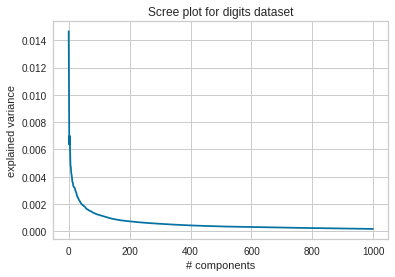

In [288]:
plt.plot(lsa.explained_variance_ratio_)
plt.xlabel('# components')
plt.ylabel('explained variance');
plt.title('Scree plot for digits dataset');

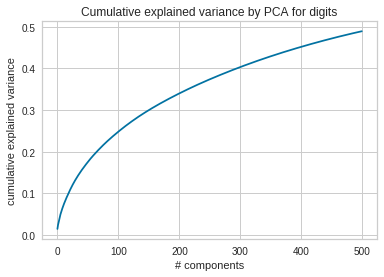

In [293]:
plt.plot(np.cumsum(lsa.explained_variance_ratio_))
plt.xlabel('# components')
plt.ylabel('cumulative explained variance');
plt.title('Cumulative explained variance by PCA for digits');

# K-means

In [509]:
def display_cluster(X,km=[],num_clusters=0):
    color = 'brgcmyk'
    alpha = 0.5
    s = 20
    if num_clusters == 0:
        plt.scatter(X[:,0],X[:,1],c = color[0],alpha = alpha,s = s)
    else:
        for i in range(num_clusters):
            plt.scatter(X[km.labels_==i,0],X[km.labels_==i,1],c = color[i],alpha = alpha,s=s, label=i)
                            
            plt.scatter(km.cluster_centers_[i][0],km.cluster_centers_[i][1],c = 'k', marker='$%d$' % i, s = 600)

## K-means clustering with NMF 

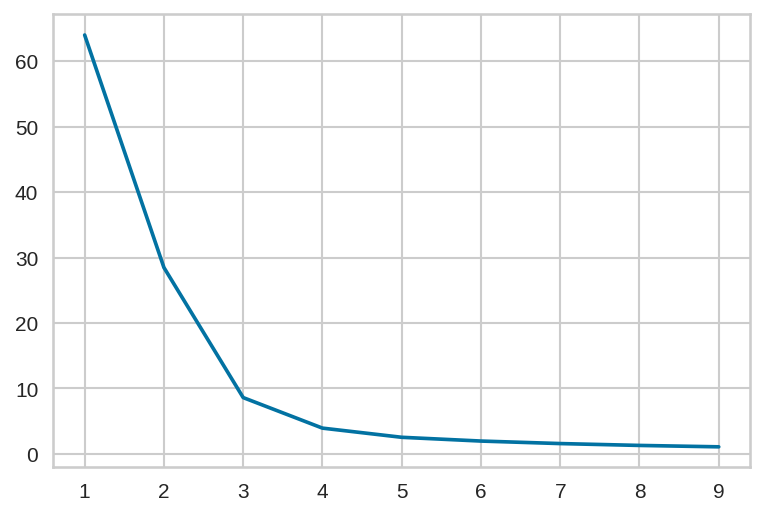

In [409]:
### Choosing the best K
plt.figure(dpi=150)
arr = [] 
ks=[]
for i in range(1,10):
    ks.append(i)
    num_clusters = i
    km = KMeans(n_clusters=num_clusters)
    km.fit(doc_topic_nmf)
    arr.append(km.inertia_)
plt.plot(ks,arr)

In [447]:
num_clusters = 4
km = KMeans(n_clusters=num_clusters)
km.fit(doc_topic_nmf)
pd.Series(km.labels_).value_counts()

0    10056
2     1001
1      799
3      325
dtype: int64

In [501]:
 df = df.assign(km_cluster_mnf = pd.Series(km.predict(doc_topic_nmf)) )

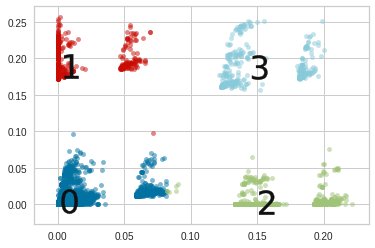

In [510]:
display_cluster((doc_topic_nmf),km, num_clusters)

## K-means clustering with LSA 

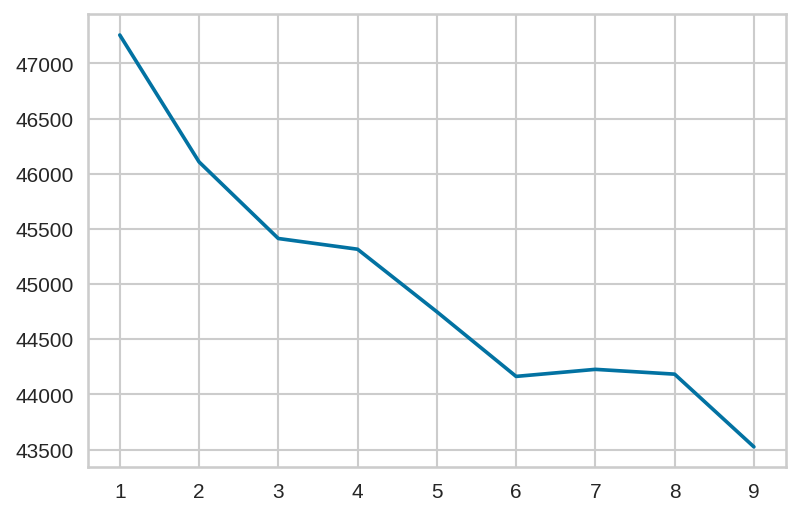

In [296]:
### Choosing the best K
plt.figure(dpi=150)
arr = [] 
ks=[]
for i in range(1,10):
    ks.append(i)
    num_clusters = i
    km = KMeans(n_clusters=num_clusters)
    km.fit(doc_topic)
    arr.append(km.inertia_)
plt.plot(ks,arr)

In [299]:
num_clusters_2 = 3
km_2 = KMeans(n_clusters=num_clusters_2)
km_2.fit(doc_topic)
pd.Series(km_2.labels_).value_counts()

1    10063
2     1320
0      798
dtype: int64

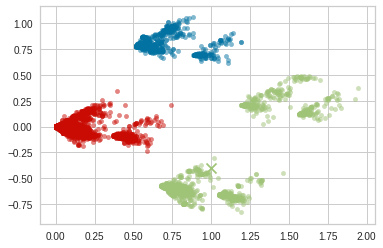

In [300]:
display_cluster((doc_topic),km_2, num_clusters_2)

# UMAP with NMF

/home/arwa/anaconda3/envs/metis/lib/python3.6/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../anaconda3/envs/metis/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))
/home/arwa/anaconda3/envs/metis/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 8 separate connected components using meta-embedding (experimental)
  n_components


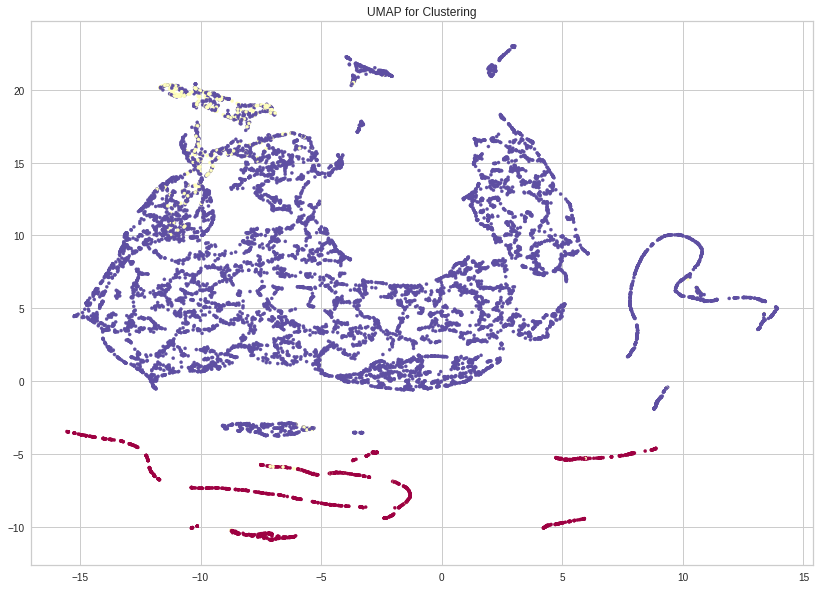

In [362]:
import sklearn.cluster as cluster
from sklearn.cluster import KMeans
import umap
fit = umap.UMAP(random_state=42)
trans = fit.fit_transform(doc_topic_nmf)

Cluster = cluster.KMeans(n_clusters=3,random_state=42).fit_predict(doc_topic)

fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(trans[:, 0], trans[:, 1], s=10,c=Cluster,cmap='Spectral', alpha=1.0)
plt.title('UMAP for Clustering');

# UMAP with NMF

/home/arwa/anaconda3/envs/metis/lib/python3.6/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../anaconda3/envs/metis/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))
/home/arwa/anaconda3/envs/metis/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 8 separate connected components using meta-embedding (experimental)
  n_components
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value f

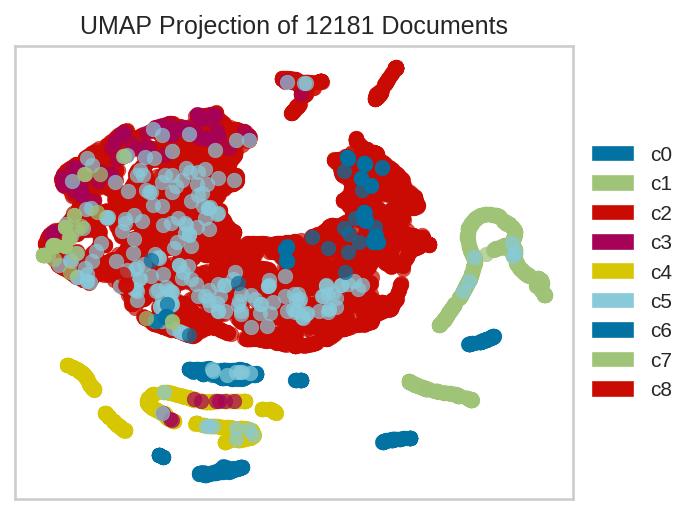

In [363]:
plt.figure(dpi=150)

umap = UMAPVisualizer()
umap.fit(doc_topic_nmf, ['c{}'.format(c) for c in km.labels_])
umap.show()

# Spectral Clustering

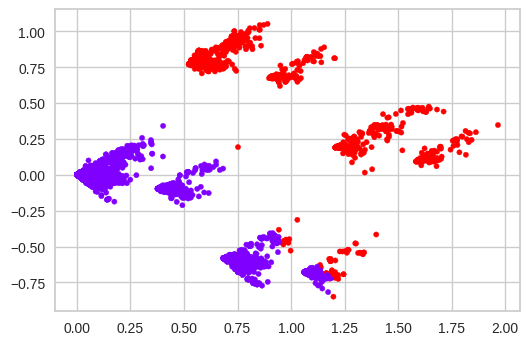

In [514]:
from sklearn.cluster import SpectralClustering
sc = SpectralClustering(n_clusters=2)
ypred = sc.fit_predict(doc_topic_nmf)
#x,y = zip(*doc_topic_vmf)
plt.figure(dpi=100)
plt.scatter(doc_topic[:,0],doc_topic[:,1],c=plt.cm.rainbow(ypred*800),s=14);

# DBSCAN

In [265]:
# Standardize our data for DBSCAN and fit DBSCAN
X = StandardScaler().fit_transform(doc_topic_nmf)
db = DBSCAN(eps=0.6, min_samples=3).fit(X)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

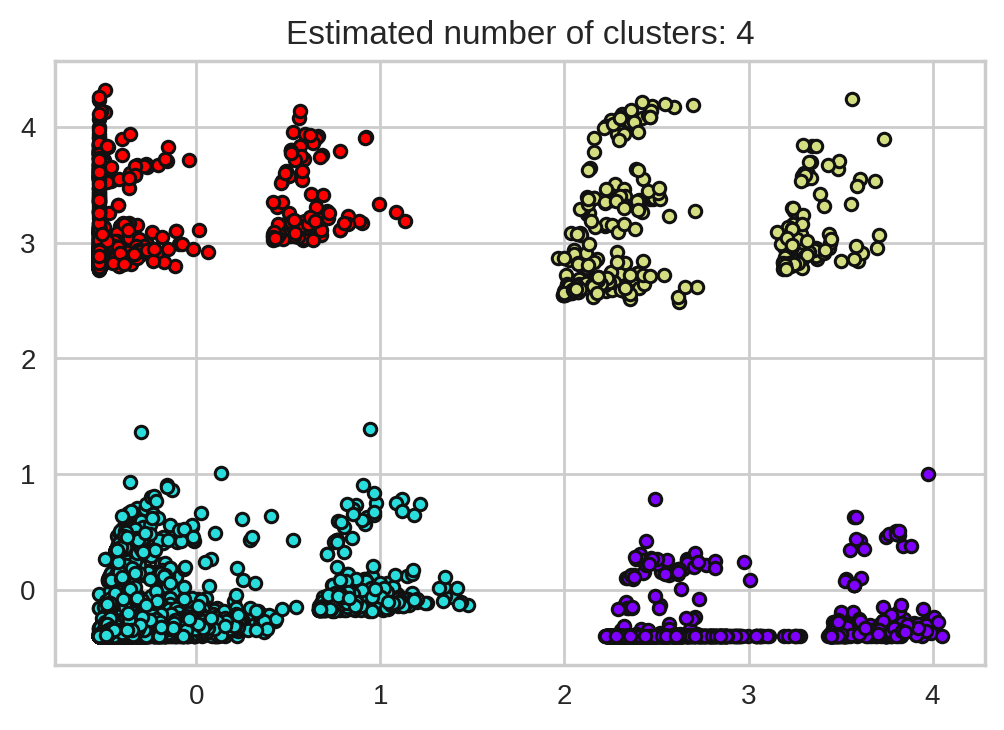

In [277]:
# Let's find the observations DBSCAN called "core"
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

unique_labels = set(labels)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))
plt.figure(dpi=200)
show_core = True
show_non_core = True
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'

    class_member_mask = (labels == k)
    if show_core:
        xy = X[class_member_mask & core_samples_mask]
        x, y = xy[:,0], xy[:,1]
        plt.scatter(x, y, c=col, edgecolors='k',  s=20, linewidths=1.1) # add black border for core points
    
    if show_non_core:
        xy = X[class_member_mask & ~core_samples_mask]
        x, y = xy[:,0], xy[:,1]
        plt.scatter(x, y, c=col, s=20, linewidths=1.1)

plt.title('Estimated number of clusters: %d' % n_clusters_);

In [515]:
# from sklearn.manifold import TSNE

# tsne_lsa_model = TSNE(n_components=3, perplexity=50,
#                       learning_rate=100, n_iter=2000, verbose=1,
#                       random_state=0, angle=0.75)
# tsne_lsa_vectors = tsne_lsa_model.fit_transform(doc_topic_nmf)